# Notebook for deep learning (basic concepts)

In this notebook we implemented de basic neural net framework. The idea is describe the basic concepts of neural net definition and the way to implement backpropagation derivation.

Some usefull references and tutorials are:

- https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/
- https://www.youtube.com/watch?v=GlcnxUlrtek
- http://neuralnetworksanddeeplearning.com/chap3.html
- https://www.youtube.com/watch?v=-YRB0eFxeQA&list=PLE6Wd9FR--EfW8dtjAuPoTuPcqmOV53Fu&index=10
- https://www.youtube.com/watch?v=PpFTODTztsU&list=PL6Xpj9I5qXYEcOhn7TqghAJ6NAPrNmUBH&index=8
- https://stats.stackexchange.com/questions/235528/backpropagation-with-softmax-cross-entropy


Currently we are using Caffe:
- http://christopher5106.github.io/deep/learning/2015/09/04/Deep-learning-tutorial-on-Caffe-Technology.html
- http://www.andrewjanowczyk.com/real-time-data-augmentation-using-nvidia-digits-python-layer/





In [11]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
%matplotlib inline


Neural network could be seen as a function J(x), an example of a simple net is:

    J(x) = 1/2(y - sigm( W2*( W1*x + b1) +b2 ) )

then can be defined:

    z_1 = x
    z_2 = W1*z_1 + b1
    z_3 = W2*z_2 + b2
    z_4 = sigm( z_3 )
    z_5 = 1/2(y-z_4)

Train the net means obtain parameters {w1, w2} that minimize the function J(x).
Descend gradient iterative solution update net weights such that:

    min_{W_i} J(x)
    
Weights update could be done as:

    {W_i}^t = {W_i}^t-1 + delta * grad J(x)
    




## Caffe layers interface

Caffe has a layer interface with functions to compute forward() and backward(). Also, the interface have two methods (not covered in this example) setup() and reshape() for automatically set the parameters and quantity of neurons in the layer depending on input data size. Caffe currently allows python layers implementation.

In [4]:
# Example of generic Layer class 
#        + ---- -+
# z ---> | layer | -- f(z) -->
#        +-------+ <-------- (dz/dx)_i+1 ------
#         |      |
#    df(z)/dx_i  df(z)/dW_i

class layer(object):
    
    def forward(self, param):
        raise NotImplementedError

    def backward(self, param):
        raise NotImplementedError


Lets implement a layer for inner product. For this only forward() and backward() methods need to be defined. Backward method referes to layer derivative. Because this layer depends on input vector x and weights W, derivative respect both must be calculated. 'dzdx' parameter refers to propagated error.

In [5]:
# Inner layer class
# Ecuation:
#    z = W*x + b 
#   dz/dx_i = W*(dz/dx_{i+1}) 
#   dz/dw_i = x*(dz/dx_{i+1}) 
#
class inner(layer):

    # z = W*x + b 
    def forward(self, param): 
        return np.dot(param['w'],param['x']);

    # dz/dx_i = W*(dz/dx_{i+1}) 
    # dz/dw_i = x*(dz/dx_{i+1})
    def backward(self, param):
        return np.dot(param['w'].T, param['dzdx']), np.dot(param['dzdx'],param['x'].T); 
    

And for sigmoid function:

In [8]:
# Sigmoid layer class
# Ecuation:
#   z = sigm(x) = 1/(1+exp(-x))
#   dz/dx = sigm(x)(1-sigm(x)) *(dz/dx_i+1) 
#
class sigm(layer):
    
    def forward(self, param): 
        return self._sigm(param['x']);

    def backward(self, param):
        return self._sigm(param['x'])*(1.0-self._sigm(param['x']))*param['dzdx']; 

    def _sigm(self, x): return 1.0/(1.0 + np.exp(-x));
    

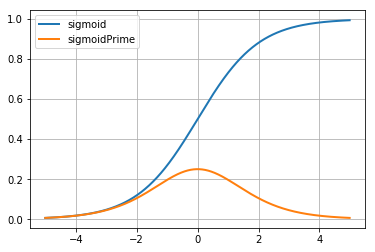

In [10]:
x = np.arange(-5,5,0.01)
plt.plot(x, sigm().forward({'x':x}), linewidth=2)
plt.plot(x, sigm().backward({'x':x, 'dzdx':1}), linewidth=2)
plt.grid(1)
plt.legend(['sigmoid', 'sigmoidPrime'])

Now, lets define or loss function. In this case correspond to MSE. For custom loss implementation only forward and backward definition is needed. An example of custom loss layer in caffe with python is given in https://chrischoy.github.io/research/caffe-python-layer/.
Tensorflow use the same idea. If you define a custom loss function with existing operations tf take derivative for you, example:

    loss_mse = 1/n(sum((y-y_)^2)))

can be defined as:

    cost = tf.reduce_mean(tf.square(tf.sub(y,y_)))

in other case c++ implementation must be done with the same idea (functions to do forward and backwards).

In [21]:
# Loss layer class
# Ecuation:
#   z = 1/2 (y-x)^2
#   dz/dx = (x-y)*(dz/dx_i+1) 
#   note: dz/dx_n = 1  
#
class loss(layer):
    
    def forward(self, param):         
        return  (1.0/(2.0*len(param['y']))*np.sum((param['y']-param['x'])**2));

    def backward(self, param):
        return (param['x']-param['y'])*param['dzdx']; 


With this, evaluation (forward) in previous network can be defined as:

In [22]:
# Create cost function neural netword
# Demo
#         +--------+    +--------+     +--------+              +--------+
#   ----> | inner  |--> | inner  |---> | sigm   | ---->(*)---> | loss   |
#         +--------+    +--------+     +--------+              +--------+

# Const function
def costFunc( x, w1, w2):
    '''
    forward function
    Entrada:
        * x vector nxm. m featurs
        * w1, w2 weigths
    Return:
        * z4
    
    Note: b=0
    '''

    z1 = x;
    z2 = inner().forward({'x':z1, 'w':w1}) 
    z3 = inner().forward({'x':z2, 'w':w2}) 
    z4 =  sigm().forward({'x':z3});
    return z4;




An example of network initialization and evaluation:

In [23]:
# create data

# data
x = np.matrix([[1,2,3]], dtype=np.float64).T;
y = np.matrix([1.0], dtype=np.float64);

# init weights
w1 = np.matrix([[0.1, 0.2, 0.3],[0.1, 0.2, 0.3]], dtype=np.float64)
w2 = np.matrix([0.8, 0.2], dtype=np.float64)

# evaluate function
y_ = costFunc( x, w1, w2);
e = loss().forward({'x':y_,'y':y});

print 'Loss:',e



Loss: 0.0195656069729


For forward and backward computation:

In [15]:
# Gradind function
def gradCostFunc(x, y, w1, w2):
    '''
    Apply backward function
    Compute dervative with respect to w1 and w2
    '''
    
    # forward --->
    z1 = x;
    z2 = inner().forward({'x':z1, 'w':w1}) 
    z3 = inner().forward({'x':z2, 'w':w2}) 
    z4 =  sigm().forward({'x':z3});
    z5 = loss().forward({'x':z4, 'y':y});

    E = z5;

    # <--- backward
    l5 = 1;
    l4 = loss().backward({'x':z4, 'y':y, 'dzdx':l5} );    
    l3 = sigm().backward({'x':z3, 'dzdx':l4});
    l2, dEdW2 = inner().backward({'x':z2, 'w':w2, 'dzdx':l3});
    _ , dEdW1 = inner().backward({'x':z1, 'w':w1, 'dzdx':l2});


    return E, dEdW1, dEdW2

Then, for previous example, gradients of weights are:

In [16]:
# derivate
# grad J(x)
E, dEdW1, dEdW2 = gradCostFunc(x, y, w1, w2);


# minimization with gradien decent
# w^t = m*w^(t-1) + lr*gardJ  

print(E)
print(dEdW1)
print(dEdW2)

0.0195656069729
[[-0.02511234 -0.05022469 -0.07533703]
 [-0.00627809 -0.01255617 -0.01883426]]
[[-0.0439466 -0.0439466]]
